In [1]:
import os
import pandas as pd
from popstudies_preprocessor import build_datasets, load_curated
from popstudies_analysis import (make_word_vis, make_author_table,
                                 make_affil_plot,
                                 summarize_scrape_and_curate,
                                 gender_over_time, headline_topics,
                                 make_mwc, make_mf_topics)
%load_ext autoreload
%autoreload 2
d_path = os.path.abspath(os.path.join('..', 'data'))
figure_path = os.path.abspath(os.path.join('..', 'article',
                                           'figures'))
main_df, ref_df, auth_df = build_datasets(d_path)

In [2]:
summarize_scrape_and_curate(main_df, auth_df, ref_df, d_path)

Total number of papers in our database: 1901
Papers with no abstract: 182
There are 1858 Articles.
There are 5 Editorials.
There are 19 Erratums.
There are 2 Letters.
There are 6 Notes.
There are 11 Reviews.
Average number of authors per paper: 1.8122041031036296
Average number of references per paper: 24.76801683324566
Date of first article: 1947-01-01
Date of most recent article: 2020-09-01
Average paper length (pages): 15.44390243902439
Number of OpenAccess articles: 52


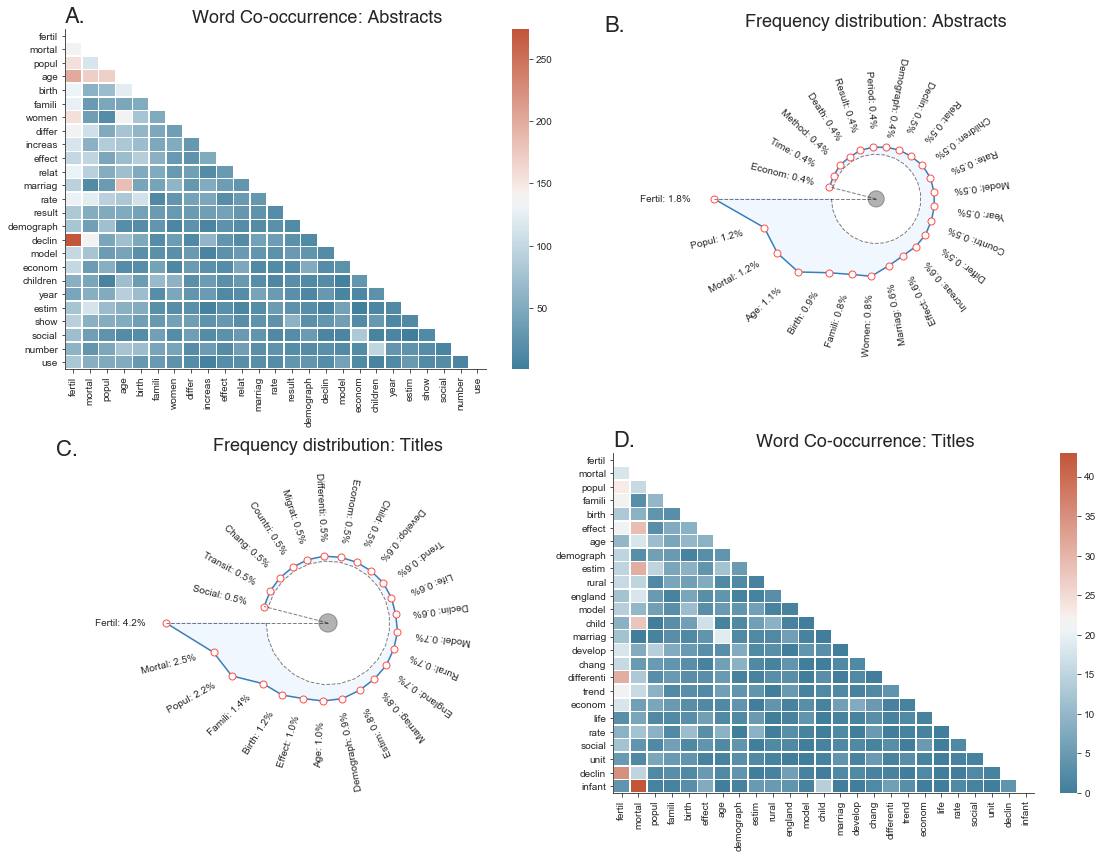

In [3]:
make_word_vis(main_df, figure_path, d_path)

In [4]:
make_author_table(auth_df, main_df, d_path, 'Papers')

C:\Dropbox\PopStudies_Review\src\popstudies_analysis.py:839: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auth_df1['authorid'] = auth_df1['authorid']


OverflowError: Python int too large to convert to C long

In [ ]:
make_author_table(auth_df, main_df, d_path, 'Cites')

In [ ]:
make_author_table(auth_df, main_df, d_path, 'H-Index')

In [ ]:
make_affil_plot(main_df, auth_df, d_path, figure_path)

In [ ]:
gender_over_time(auth_df[auth_df['forename']!='NAN'])

In [ ]:
headline_topics(main_df)

In [ ]:
main_df[main_df['Nation'].notnull()].groupby(['Nation'])['Nation'].count().sort_values(ascending=False)

In [ ]:
make_mwc(main_df)

In [ ]:
make_mf_topics(auth_df[auth_df['forename']!='NAN'], main_df, d_path)

In [18]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse as sp
import networkx as nx
import random
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.algorithms.isomorphism.isomorph import (
    graph_could_be_isomorphic as isomorphic)
auth_df = auth_df[auth_df['doi'].notnull()]
author_papers = auth_df[auth_df['authorid'].notnull()]
authors_df = author_papers[['authorid', 'indexed_name']].drop_duplicates(subset=['authorid'])
int_p_id = dict(enumerate(list(author_papers['doi'].unique())))
int_a_id = dict(enumerate(list(author_papers['authorid'].unique())))
a_int_id = {authorId:intVal for intVal,authorId in int_a_id.items()}
p_int_id = {paperId:intVal for intVal,paperId in int_p_id.items()}
author_paper_tuples = list(zip(author_papers['authorid'], author_papers['doi']))
author_paper_tuples = [(a_int_id[t[0]],p_int_id[t[1]]) for t in author_paper_tuples]
AP = sp.csc_matrix((np.ones(len(author_paper_tuples)), zip(*author_paper_tuples)))
AA = AP.dot(AP.T)
AA = np.array(AA - np.diag(AA.diagonal()))
G = nx.from_numpy_matrix(AA, parallel_edges=True)
deg_measure = nx.degree(G) 
cent_measure = nx.degree_centrality(G) 
bet_measure = nx.betweenness_centrality(G)
authors_df['degree'] = authors_df['authorid'].apply(lambda l: deg_measure[a_int_id.get(l)])
authors_df['degree_cent'] = authors_df['authorid'].apply(lambda l: cent_measure[a_int_id.get(l)])
authors_df['degree_bet'] = authors_df['authorid'].apply(lambda l: bet_measure.get(a_int_id.get(l)))
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
print('Edges in entire network: ' + str(G.number_of_edges()))
print('Nodes in entire network: ' + str(G.number_of_nodes()))
print('Density of entire network: ' + str(nx.density(G)))
print('Edges in Giant Component: ' + str(G.subgraph(Gcc[0]).number_of_edges()))
print('Nodes in Giant Component: ' + str(G.subgraph(Gcc[0]).number_of_nodes()))
print('Density of Giant Component: ' + str(nx.density(G.subgraph(Gcc[0]))))


Edges in entire network: 2317
Nodes in entire network: 2026
Density of entire network: 0.0011295138508037488
Edges in Giant Component: 926
Nodes in Giant Component: 433
Density of Giant Component: 0.009900778376528955


In [58]:
auth_df['prismcoverdate'] = auth_df['prismcoverdate'].astype('datetime64[ns]')
time_df = pd.DataFrame(index=range(1947, 2021),
                       columns=['whole_edges', 'whole_nodes', 'whole_density',
                                'giant_edges', 'giant_nodes', 'giant_density'])
for year in range(1, 75):
    year_df = auth_df[auth_df['prismcoverdate'].dt.year<1947+year]
    year_df = year_df[year_df['doi'].notnull()]
    year_author_papers = year_df[year_df['authorid'].notnull()]
    year_authors_df = year_author_papers[['authorid', 'indexed_name']].drop_duplicates(subset=['authorid'])
    int_p_id = dict(enumerate(list(year_author_papers['doi'].unique())))
    int_a_id = dict(enumerate(list(year_author_papers['authorid'].unique())))
    a_int_id = {authorId:intVal for intVal,authorId in int_a_id.items()}
    p_int_id = {paperId:intVal for intVal,paperId in int_p_id.items()}
    author_paper_tuples = list(zip(year_author_papers['authorid'], year_author_papers['doi']))
    author_paper_tuples = [(a_int_id[t[0]],p_int_id[t[1]]) for t in author_paper_tuples]
    AP = sp.csc_matrix((np.ones(len(author_paper_tuples)), zip(*author_paper_tuples)))
    AA = AP.dot(AP.T)
    AA = np.array(AA - np.diag(AA.diagonal()))
    G = nx.from_numpy_matrix(AA, parallel_edges=True)

    time_df.loc[year+1946, 'whole_edges'] = G.number_of_edges()
    time_df.loc[year+1946, 'whole_nodes'] = G.number_of_nodes()
    time_df.loc[year+1946, 'whole_density'] = nx.density(G)
    time_df.loc[year+1946, 'giant_edges'] = G.subgraph(Gcc[0]).number_of_edges()
    time_df.loc[year+1946, 'giant_nodes'] = G.subgraph(Gcc[0]).number_of_nodes()
    time_df.loc[year+1946, 'giant_density'] = nx.density(G.subgraph(Gcc[0]))
time_df[['whole_nodes', 'whole_edges']][:].plot(figsize=(4,4))

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot2grid((15, 19), (0, 0), rowspan=10, colspan=20)
ax2 = plt.subplot2grid((15, 19), (10, 1), rowspan=5, colspan=8)
ax3 = plt.subplot2grid((15, 19), (10, 10), rowspan=5, colspan=8)
pos = graphviz_layout(G, prog="neato")
C = (G.subgraph(c) for c in nx.connected_components(G))
colors1 = ['#d73027', '#3ace3a', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4']
for g in C:
    c = [random.random()] * nx.number_of_nodes(g)  # random color...
    if nx.number_of_nodes(g) == 1:
        c = colors1[0]
    elif nx.number_of_nodes(g) == 2:
        c = colors1[1]
    elif nx.number_of_nodes(g) == 3:
        c = colors1[2]
    elif nx.number_of_nodes(g) == 4:
        c = colors1[3]
    elif (nx.number_of_nodes(g)>4) and nx.number_of_nodes(g)<8:
        c = colors1[4]
    elif (nx.number_of_nodes(g)>7) and nx.number_of_nodes(g)<400:
        c = colors1[5]
    elif (nx.number_of_nodes(g)>400):
        c = colors1[6]
    nx.draw(g, pos, node_size=20, node_color=c, vmin=0.0, vmax=1.0, with_labels=False, ax=ax1)
ax1.set_title('A.', fontsize=24, loc='left', y=0.98, x=0.05)
ax2.set_title('B.', fontsize=24, loc='left', y=1.02, x=0.0)
ax3.set_title('C.', fontsize=24, loc='left', y=1.02, x=0.0)

temp_df = pd.DataFrame(authors_df.groupby(['degree'])['degree'].count()).rename({'degree':'count'}, axis=1)
temp_df['count'] = temp_df['count']/temp_df['count'].sum()
temp_df['count'].plot(markersize=8, marker='o', loglog=True, linewidth=0, markerfacecolor='w', ax=ax2)




fig_path = os.path.join(os.getcwd(), '..', 'article', 'figures')
plt.savefig(os.path.join(fig_path, 'networks.pdf'),
            bbox_inches='tight')
plt.savefig(os.path.join(fig_path, 'networks.png'),
            bbox_inches='tight', dpi=600)
plt.savefig(os.path.join(fig_path, 'networks.svg'),
            bbox_inches='tight')
plt.tight_layout(True)
sns.despine()
plt.show()